In [1]:
from google.colab import drive
import os
from datetime import datetime
import pytz


drive.mount('/content/gdrive')
Root_path   = r'/content/gdrive/MyDrive/SKIN_DISEASES'


working_dir = r'/content/sample_data/SKIN_DISEASES/'
SOURCE_dir = r'/content/sample_data/SKIN_DISEASES/ISIC_2019_Training_Input/'

# if not os.path.exists(SOURCE_dir):
#        os.mkdir(SOURCE_dir)

IST = pytz.timezone('Asia/Kolkata')
print("now =", datetime.now(IST).strftime("%d/%m/%Y %H:%M:%S"))

Mounted at /content/gdrive
now = 12/11/2023 10:17:49


In [2]:
### if not downloded in gdrive
!wget 'https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip' -P '/content/sample_data/SKIN_DISEASES'
!wget 'https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_GroundTruth.csv'  -P '/content/sample_data/SKIN_DISEASES'
!wget 'https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Metadata.csv' -P '/content/sample_data/SKIN_DISEASES'

!unzip -qq '/content/sample_data/SKIN_DISEASES/ISIC_2019_Training_Input.zip' -d '/content/sample_data/SKIN_DISEASES'
Root_path   = r'/content/sample_data/SKIN_DISEASES'

#### =========================================================================================================================================  AND COMMENT BELOW
### if already downloded in gdrive
# !unzip -qq '/content/gdrive/MyDrive/SKIN_DISEASES/ISIC_2019_Training_Input.zip' -d '/content/sample_data/SKIN_DISEASES'


--2023-11-12 04:47:49--  https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 54.231.200.137, 52.216.61.121, 52.217.113.89, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|54.231.200.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9771618190 (9.1G) [application/zip]
Saving to: ‘/content/sample_data/SKIN_DISEASES/ISIC_2019_Training_Input.zip’

ISIC_2019_Training_ 100%[===================>]   9.10G  55.6MB/s    in 3m 12s  

2023-11-12 04:51:01 (48.5 MB/s) - ‘/content/sample_data/SKIN_DISEASES/ISIC_2019_Training_Input.zip’ saved [9771618190/9771618190]

--2023-11-12 04:51:01--  https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_GroundTruth.csv
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.13.124, 3.5.1.160, 16.182.65.9, ...
Connecting

In [3]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import models, layers, backend, optimizers, regularizers, metrics #for model manipulation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

In [4]:
print("now =", datetime.now(IST).strftime("%d/%m/%Y %H:%M:%S"))

now = 12/11/2023 10:23:04


In [5]:
df_gth = pd.read_csv(Root_path+'/ISIC_2019_Training_GroundTruth.csv')
df_gth.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
MEL = 'Melanoma'
NV  = 'Melanocytic_nevus'
BCC = 'Basal_cell_carcinoma'
AK = 'Actinic_keratosis'
BKL = 'Benign_keratosis'
DF = 'Dermatofibroma'
VASC = 'Vascular_lesion'
SCC = 'Squamous_cell_carcinoma'

abbr = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']
Full_name = ['Melanoma', 'Melanocytic_nevus', 'Basal_cell_carcinoma', 'Actinic_keratosis', 'Benign_keratosis', 'Dermatofibroma', 'Vascular_lesion', 'Squamous_cell_carcinoma']

In [7]:
## prepare dataframe with image link
filepaths=[]
labels=[]
for row in range(df_gth.shape[0]):
    file_name = df_gth.loc[row][0]+ '.jpg'
    class_type = Full_name[np.argmax(df_gth.loc[row][1:].values)]
    File_path=os.path.join(SOURCE_dir, file_name)
    filepaths.append(File_path)
    labels.append(class_type)

Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
total_df=pd.concat([Fseries, Lseries], axis=1)

classes=sorted(total_df['labels'].unique())
class_count=len(classes)

total_df.head()

,filepaths,labels
0,/content/sample_data/SKIN_DISEASES/ISIC_2019_Training_Input/ISIC_0000000.jpg,Melanocytic_nevus
1,/content/sample_data/SKIN_DISEASES/ISIC_2019_Training_Input/ISIC_0000001.jpg,Melanocytic_nevus
2,/content/sample_data/SKIN_DISEASES/ISIC_2019_Training_Input/ISIC_0000002.jpg,Melanoma
3,/content/sample_data/SKIN_DISEASES/ISIC_2019_Training_Input/ISIC_0000003.jpg,Melanocytic_nevus
4,/content/sample_data/SKIN_DISEASES/ISIC_2019_Training_Input/ISIC_0000004.jpg,Melanoma


In [8]:
## Train test and validation split
## ----------------------------------------------

train_val_df, test_df = train_test_split(total_df, stratify = total_df["labels"], test_size = 0.1, random_state = 42)
train_df, valid_df = train_test_split(train_val_df, stratify = train_val_df["labels"], test_size = 0.2, random_state = 42)

## ---------------------------------------------------------
Data_counts_df = pd.DataFrame()
Data_counts_df["Class"] = classes

Total_df_counts = total_df.labels.value_counts().reset_index()
Total_df_counts.rename(columns={'labels': 'Total', 'index': 'Class'}, inplace=True)
Data_counts_df = Data_counts_df.merge(Total_df_counts, on = 'Class')


train_df_counts = train_df.labels.value_counts().reset_index()
train_df_counts.rename(columns={'labels': 'Train', 'index': 'Class'}, inplace=True)
Data_counts_df = Data_counts_df.merge(train_df_counts, on = 'Class')

validation_df_counts = valid_df.labels.value_counts().reset_index()
validation_df_counts.rename(columns={'labels': 'Val', 'index': 'Class'}, inplace=True)
Data_counts_df = Data_counts_df.merge(validation_df_counts, on = 'Class')

test_df_counts = test_df.labels.value_counts().reset_index()
test_df_counts.rename(columns={'labels': 'Test', 'index': 'Class'}, inplace=True)
Data_counts_df = Data_counts_df.merge(test_df_counts, on = 'Class')


Data_counts_df

,Class,Total,Train,Val,Test
0,Actinic_keratosis,867,624,156,87
1,Basal_cell_carcinoma,3323,2393,598,332
2,Benign_keratosis,2624,1889,472,263
3,Dermatofibroma,239,172,43,24
4,Melanocytic_nevus,12875,9269,2318,1288
5,Melanoma,4522,3256,814,452
6,Squamous_cell_carcinoma,628,452,113,63
7,Vascular_lesion,253,182,46,25


In [9]:
n=2000                   # number of minimum train images per class
# img_size = (150,150)

# mod_num = 'S'            #EfficientNetV2 - small
# mod_num = 'B0'            #EfficientNetV2 - B0
# mod_num = 'B1'            #EfficientNetV2 - B1
mod_num = 'B2'            #EfficientNetV2 - B2
# mod_num = 'B3'            #EfficientNetV2 - B3


# img_size = (384,384)   # best for EfficientNetV2 -s, got memeory issue

IMG_SIZE = (224,224)
img_size = IMG_SIZE

BATCH_SIZE = 64
batch_size = BATCH_SIZE


lr=.001
epochs=20
# epochs=2
ask_epoch=10

In [10]:
### CREATE EXTRA AUGMENTED images if a call has less sample

def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)


    # gen= ImageDataGenerator(
    #       # rescale=1.0/255.0,      # Rescale pixel values to [0, 1]
    #       rotation_range=25,      # Randomly rotate images by up to 25 degrees
    #       width_shift_range=0.3,  # Randomly shift the width of images
    #       height_shift_range=0.3, # Randomly shift the height of images
    #       horizontal_flip=True,   # Randomly flip images horizontally
    #       shear_range=0.3,        # Apply shear transformations
    #       zoom_range=0.4,         # Randomly zoom into images
    #       fill_mode='nearest'     # Fill empty pixels with the nearest value
    #   )

    # Note: each Keras Application expects a specific kind of input preprocessing. For EfficientNetV2, by default input preprocessing is included as a part of the model
    # (as a Rescaling layer), and thus tf.keras.applications.efficientnet_v2.preprocess_input is actually a pass-through function. In this use case, EfficientNetV2 models
    # expect their inputs to be float tensors of pixels with values in the [0-255] range. At the same time, preprocessing as a part of the model (i.e. Rescaling layer)
    # can be disabled by setting include_preprocessing argument to False. With preprocessing disabled EfficientNetV2 models expect their inputs to be float tensors of pixels with values in the [-1, 1] range.

    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

In [11]:
train_df=balance(train_df, n, working_dir, IMG_SIZE)

print("-----------------------------------------------------")
train_df_counts = train_df.labels.value_counts().reset_index()
train_df_counts.rename(columns={'labels': 'New_Train', 'index': 'Class'}, inplace=True)
Data_counts_df = Data_counts_df.merge(train_df_counts, on = 'Class')
Data_counts_df

Initial length of dataframe is  18237
Found 624 validated image filenames.
Found 1889 validated image filenames.
Found 452 validated image filenames.
Found 172 validated image filenames.
Found 182 validated image filenames.
Total Augmented images created=  6681
Length of augmented dataframe is now  24918
-----------------------------------------------------


,Class,Total,Train,Val,Test,New_Train
0,Actinic_keratosis,867,624,156,87,2000
1,Basal_cell_carcinoma,3323,2393,598,332,2393
2,Benign_keratosis,2624,1889,472,263,2000
3,Dermatofibroma,239,172,43,24,2000
4,Melanocytic_nevus,12875,9269,2318,1288,9269
5,Melanoma,4522,3256,814,452,3256
6,Squamous_cell_carcinoma,628,452,113,63,2000
7,Vascular_lesion,253,182,46,25,2000


In [12]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):

    trgen=ImageDataGenerator(horizontal_flip=True)
    t_and_v_gen=ImageDataGenerator()


    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df,
                                        x_col='filepaths',
                                        y_col='labels',
                                        target_size=img_size,
                                        class_mode='categorical',
                                        color_mode='rgb',
                                        shuffle=True,
                                        batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line


    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df,
                                              x_col='filepaths',
                                              y_col='labels',
                                              target_size=img_size,
                                              class_mode='categorical',
                                              color_mode='rgb',
                                              shuffle=False,
                                              batch_size=batch_size)

    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df,
                                             x_col='filepaths',
                                             y_col='labels',
                                             target_size=img_size,
                                             class_mode='categorical',
                                             color_mode='rgb',
                                             shuffle=False,
                                             batch_size=test_batch_size)

    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes


In [13]:
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(BATCH_SIZE, train_df, test_df, valid_df, IMG_SIZE)

Found 24918 validated image filenames belonging to 8 classes.
Found 4560 validated image filenames belonging to 8 classes.
Found 2534 validated image filenames belonging to 8 classes.
test batch size:  14   test steps:  181  number of classes :  8


In [14]:
# def show_image_samples(gen ):
#     t_dict=gen.class_indices
#     classes=list(t_dict.keys())
#     images,labels=next(gen) # get a sample batch from the generator
#     plt.figure(figsize=(25, 25))
#     length=len(labels)
#     if length<25:   #show maximum of 25 images
#         r=length
#     else:
#         r=25
#     for i in range(r):
#         plt.subplot(5, 5, i + 1)
#         image=images[i] /255
#         plt.imshow(image)
#         index=np.argmax(labels[i])
#         class_name=classes[index]
#         plt.title(class_name, color='blue', fontsize=18)
#         plt.axis('off')
#     plt.show()


# show_image_samples(train_gen )

In [15]:
def print_in_color(text, text_color=(255, 255, 255), background_color=(0, 0, 0)):
    r, g, b = text_color
    r_bg, g_bg, b_bg = background_color
    print(f"\033[38;2;{r};{g};{b};48;2;{r_bg};{g_bg};{b_bg}m{text}\033[m")

In [16]:
## DOWNLOAD model and add FC layers

def make_model(img_size, lr, mod_num):

    img_shape=(img_size[0], img_size[1], 3)

    if mod_num == 'S':
        base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2S(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNetV2 S model'

    if mod_num == 'B0':
        base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNetV2 B0 model'

    if mod_num == 'B1':
        base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNetV2 B1 model'

    if mod_num == 'B2':
        base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNetV2 B2 model'

    if mod_num == 'B3':
        base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNetV2 B3 model'


    # if mod_num == 0:
    #     base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    #     msg='Created EfficientNet B0 model'
    # elif mod_num == 3:
    #     base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    #     msg='Created EfficientNet B3 model'
    # elif mod_num == 5:
    #     base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    #     msg='Created EfficientNet B5 model'

    # else:
    #     base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    #     msg='Created EfficientNet B7 model'

    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)
    x = Dense(256,activation='relu')(x)

    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)

    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

In [17]:
model=make_model(img_size, lr, mod_num) # using B3 model by default

# Show the model architecture
model.summary()


35839040/35839040 [==============================] - 0s 0us/step
Created EfficientNetV2 B2 model with initial learning rate set to 0.001
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                        

In [18]:
UPDATES_PER_EPOCH = train_df.shape[0] // BATCH_SIZE # + 1
VALIDATION_STEPS = valid_df.shape[0] // BATCH_SIZE
print("Number of training and validation steps: {} and {}".format(UPDATES_PER_EPOCH, VALIDATION_STEPS))


# ---------------------------------------------------------------------------------
# from sklearn.utils import compute_class_weight

# # train_gen, train_dfx = make_train_gen(train_df)
# train_classes = train_gen.classes

# class_weights = compute_class_weight(
#                                         class_weight = "balanced",
#                                         classes = np.unique(train_classes),
#                                         y = train_classes
#                                     )
# class_weights = dict(zip(np.unique(train_classes), class_weights))
# print(class_weights)

# ---------------------------------------------------------------------------------



print("now =", datetime.now(IST).strftime("%d/%m/%Y %H:%M:%S"))
# ---------------------------------------------------------------------------------

early_stopping = keras.callbacks.EarlyStopping( monitor='val_accuracy',patience=5,restore_best_weights=True)
history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=[early_stopping])

# history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen, class_weight = class_weights, callbacks=[early_stopping])

# ---------------------------------------------------------------------------------
print("now =", datetime.now(IST).strftime("%d/%m/%Y %H:%M:%S"))


Number of training and validation steps: 389 and 71
now = 12/11/2023 10:25:51
Epoch 1/20
390/390 [==============================] - 495s 1s/step - loss: 4.4952 - accuracy: 0.6529 - val_loss: 2.2811 - val_accuracy: 0.7151
Epoch 2/20
390/390 [==============================] - 423s 1s/step - loss: 1.6009 - accuracy: 0.7586 - val_loss: 1.2433 - val_accuracy: 0.7533
Epoch 3/20
390/390 [==============================] - 413s 1s/step - loss: 0.9356 - accuracy: 0.8098 - val_loss: 0.8832 - val_accuracy: 0.7803
Epoch 4/20
390/390 [==============================] - 405s 1s/step - loss: 0.6595 - accuracy: 0.8487 - val_loss: 0.7713 - val_accuracy: 0.7857
Epoch 5/20
390/390 [==============================] - 402s 1s/step - loss: 0.5142 - accuracy: 0.8777 - val_loss: 0.6853 - val_accuracy: 0.8061
Epoch 6/20
390/390 [==============================] - 422s 1s/step - loss: 0.4192 - accuracy: 0.8999 - val_loss: 0.7219 - val_accuracy: 0.7976
Epoch 7/20
390/390 [==============================] - 394s 1s/st

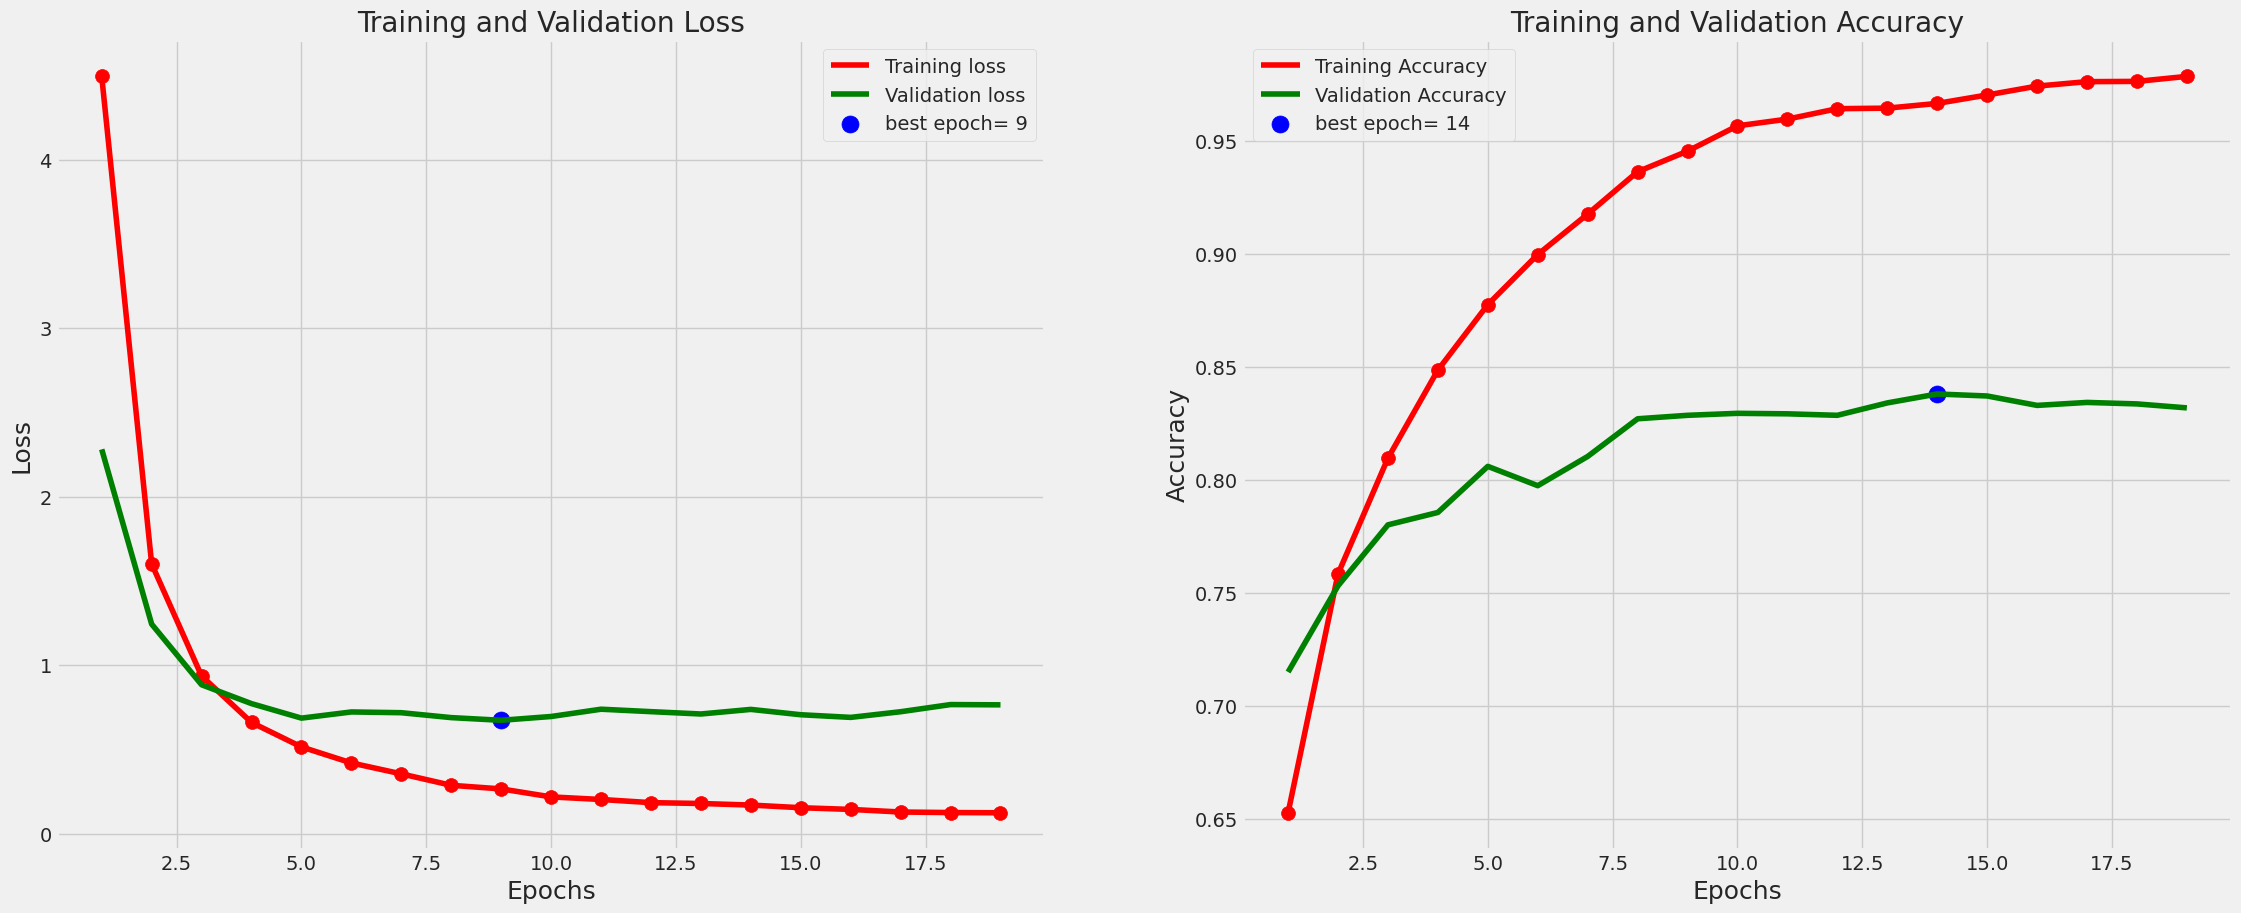

In [19]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)

    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)

    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))

    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()

    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout
    plt.show()
    return index_loss

loss_index=tr_plot(history,0)



181/181 [==============================] - 40s 203ms/step
there were 383 errors in 2534 tests for an accuracy of  84.89


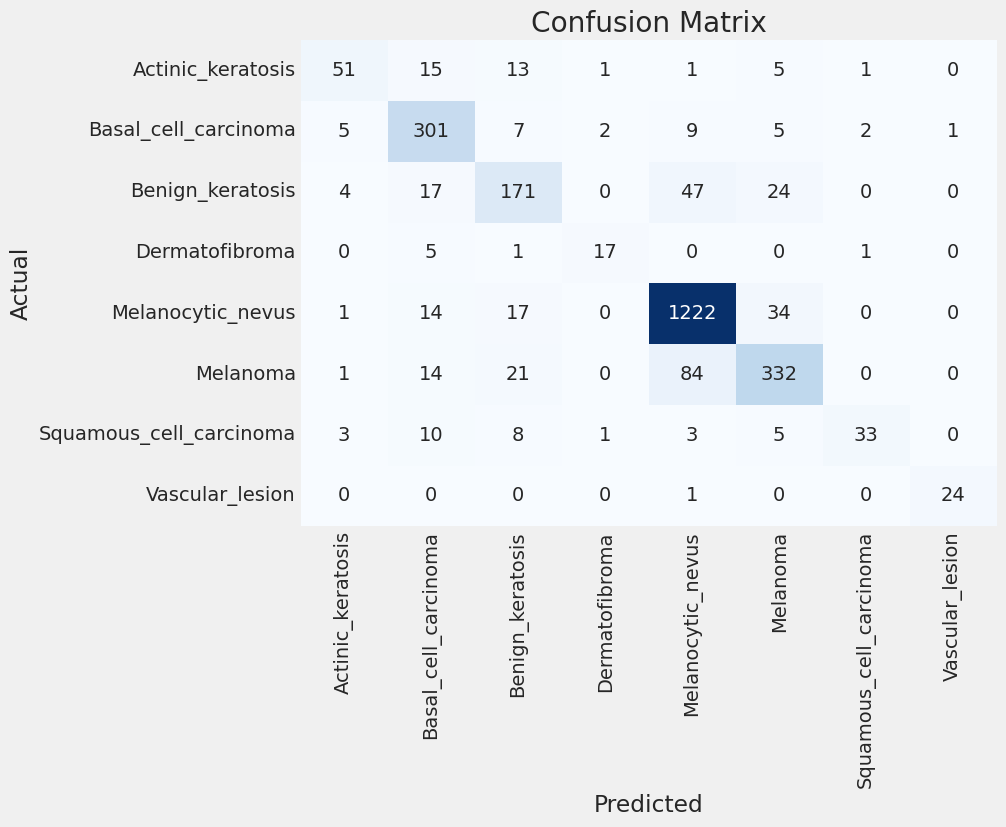

Classification Report:
----------------------
                          precision    recall  f1-score   support

      Actinic_keratosis     0.7846    0.5862    0.6711        87
   Basal_cell_carcinoma     0.8005    0.9066    0.8503       332
       Benign_keratosis     0.7185    0.6502    0.6826       263
         Dermatofibroma     0.8095    0.7083    0.7556        24
      Melanocytic_nevus     0.8939    0.9488    0.9205      1288
               Melanoma     0.8198    0.7345    0.7748       452
Squamous_cell_carcinoma     0.8919    0.5238    0.6600        63
        Vascular_lesion     0.9600    0.9600    0.9600        25

               accuracy                         0.8489      2534
              macro avg     0.8348    0.7523    0.7844      2534
           weighted avg     0.8463    0.8489    0.8444      2534

Accuracy Score: 0.8488555643251776
Precision Score: 0.8463007648999076
Recall Score: 0.8488555643251776
F1 Score: 84.4423245612267
AUC-ROC Score: Nan


In [20]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#
# def predictor(test_gen, test_steps):

y_pred= []
error_list=[]
error_pred_list = []
y_true=test_gen.labels
classes=list(test_gen.class_indices.keys())
class_count=len(classes)
errors=0
preds=model.predict(test_gen, verbose=1)
tests=len(preds)
for i, p in enumerate(preds):
    pred_index=np.argmax(p)
    true_index=test_gen.labels[i]  # labels are integer values
    if pred_index != true_index: # a misclassification has occurred
        errors=errors + 1
        file=test_gen.filenames[i]
        error_list.append(file)
        error_class=classes[pred_index]
        error_pred_list.append(error_class)
    y_pred.append(pred_index)

acc=( 1-errors/tests) * 100
msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground

ypred=np.array(y_pred)
ytrue=np.array(y_true)

# f1score=f1_score(ytrue, ypred, average='weighted')* 100
accuracy_score = accuracy_score(y_true, y_pred)
precision_score = precision_score(ytrue, ypred, average = "weighted")
recall_score = recall_score(ytrue, ypred, average = "weighted")
f1score = f1_score(ytrue, ypred, average = "weighted")* 100
auc_roc_score = "Nan"
# metrics.roc_auc_score(ytrue, ypred, average = "weighted")
# print("classification report")
# print(classification_report(ytrue, ypred))

if class_count <=30:
    cm = confusion_matrix(ytrue, ypred )
    # plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
    plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
print("Classification Report:\n----------------------\n", clr)

# return errors, tests, error_list, error_pred_list, f1score , accuracy_score, precision_score, recall_score, auc_roc_score



## ----------------------------------------------------------------------------------------

# errors, tests, error_list, error_pred_list, f1score , accuracy_score, precision_score, recall_score, auc_roc_score = predictor(test_gen, test_steps)

if len(error_list) > 0 and len(error_list)<25:
    msg='Below is a list of test files that were miss classified \n'
    print_in_color(msg)
    msg='{0:^30s}{1:^30s}'.format('Test File', ' Predicted as')
    print_in_color(msg)
    for i in range(len(error_list)):
        fpath=error_list[i]
        split=fpath.split('/')
        f=split[4]+ '-' + split[5]
        print(f'{f:^30s}{error_pred_list[i]:^30s}')


print("Accuracy Score:", accuracy_score)
print("Precision Score:", precision_score)
print("Recall Score:", recall_score)
print("F1 Score:", f1score)
# print("specificity:", specificity)
print("AUC-ROC Score:", auc_roc_score)

# target_names = ['class 0', 'class 1', 'class 2']
# print(classification_report(y_true, y_pred, target_names=target_names))

,class,precision,recall,f1-score,support,ROC_AUC_score
0,Actinic_keratosis,0.784615,0.586207,0.671053,87.000000,0.790243
1,Basal_cell_carcinoma,0.800532,0.906627,0.850282,332.000000,0.936283
2,Benign_keratosis,0.718487,0.650190,0.682635,263.000000,0.810344
3,Dermatofibroma,0.809524,0.708333,0.755556,24.000000,0.853370
4,Melanocytic_nevus,0.893928,0.948758,0.920527,1288.000000,0.916193
5,Melanoma,0.819753,0.734513,0.774796,452.000000,0.849725
6,Squamous_cell_carcinoma,0.891892,0.523810,0.660000,63.000000,0.761095
7,Vascular_lesion,0.960000,0.960000,0.960000,25.000000,0.979801
8,accuracy,0.848856,0.848856,0.848856,0.848856,NaN
9,macro avg,0.834841,0.752305,0.784356,2534.000000,NaN


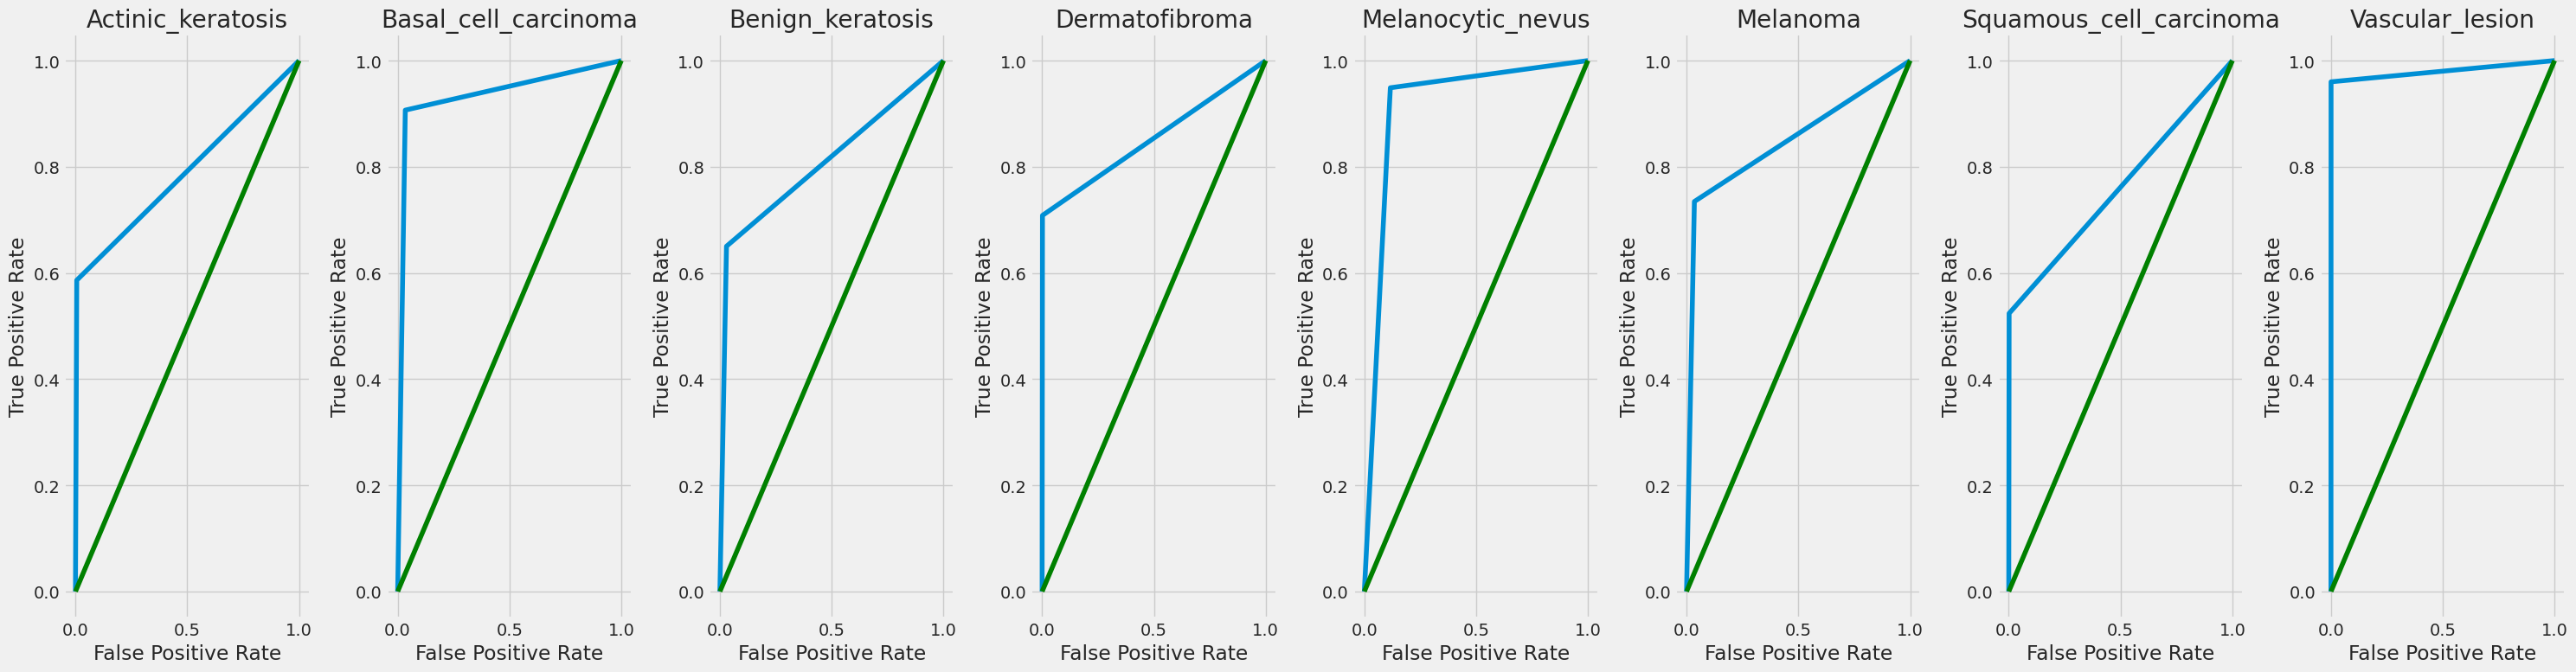

In [21]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.

    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.

    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations

    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes

    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''

    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate

    return tpr, fpr

def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).

    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()

    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")


## ---------------------------------------------------------
score_df = pd.DataFrame(columns=["Class","tpr","fpr", "specificity", "ROC_AUC_score"])
score_df["Class"] = classes



# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (30, 8))
bins = [i/20 for i in range(20)] + [1]
classes = classes
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    # print(c)

    # Prepares an auxiliar dataframe to help with the plots
    df_aux = test_df.copy()
    df_aux['class'] = [1 if y == i else 0 for y in ytrue]
    df_aux['prob'] = [1 if y == i else 0 for y in ypred]
    df_aux = df_aux.reset_index(drop = True)

    # # Plots the probability distribution for the class and the rest
    # ax = plt.subplot(2, 3, i+1)
    # sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    # ax.set_title(c)
    # ax.legend([f"Class: {c}", "Rest"])
    # ax.set_xlabel(f"P(x = {c})")

    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(1, len(classes), i+1)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title(classes[i])

    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    # print(c," : ", roc_auc_ovr[c])
plt.tight_layout()


##=========================================================================================
clr2 = classification_report(y_true, y_pred, target_names=classes, digits= 4,output_dict=True)
score_df = pd.DataFrame(clr2).transpose().reset_index()
score_df = score_df.rename(columns={'index': 'class'})
# # roc_auc_ovr
roc = pd.DataFrame(roc_auc_ovr.items(), columns=['class', 'ROC_AUC_score'])
score_df = score_df.merge(roc, on = ['class'], how = 'left')
score_df


In [22]:
# model_Name = 'efficientnetV2_S_img224_2kimgAug'
# # # model.save('/content/gdrive/MyDrive/SKIN_DISEASES/Models/efficientnet')
# # # save model
# # # serialize model to JSON
# skinlesion2_json = model.to_json()

# model_path   = r'/content/gdrive/MyDrive/SKIN_DISEASES/Models'

# if not os.path.exists(model_path):
#        os.mkdir(model_path)


# with open(f"{model_path}/{model_Name}.json", "w") as json_file:
#     json_file.write(skinlesion2_json)

# # # serialize weights to HDF5
# model.save_weights(f"{model_path}/{model_Name}.h5")
# print("Saved model to disk")